In [196]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import jsonlines
import statistics
import os
import glob
import csv
import geopandas
import cartopy.crs as ccrs
import matplotlib.font_manager as font_manager
from zipfile import ZipFile
from matplotlib.patches import Patch
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib import colors as pltColors
from matplotlib import ticker
from datetime import datetime


# from matplotlib import colors
# from matplotlib import ticker

# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)

# We are using the tab10 colormap
cols = plt.get_cmap("tab10").colors


fe = font_manager.FontEntry(fname="/Users/Library/Fonts/cmu.sans-serif-medium.ttf", name="CMU Sans Serif")
font_manager.fontManager.ttflist.insert(0,fe)

In [153]:
dataset_folder_name = 'dataset-zipped'

netmet_msm_path = f'../{dataset_folder_name}/netmet-measurements/'
helper_files_path = f'../{dataset_folder_name}/helper-files/'
cloudflare_msm_path = f'../{dataset_folder_name}/cloudflare-measurements/'
simulation_msm_path = f'../{dataset_folder_name}/simulation-analysis/'

all_msm_file_paths_file_name_dict = {
    netmet_msm_path : 'netmet-results.zip',
    helper_files_path : 'helper.zip',
    cloudflare_msm_path : 'cloudflare-AIM.zip',
    simulation_msm_path : 'simulations.zip'
}

for file_path, file_name in all_msm_file_paths_file_name_dict.items():
    full_file_path = f'{file_path}{file_name}'
    extract_to_folder_name = file_name.split('.')[0]
    with ZipFile(full_file_path) as zObject:
        extract_path = f'{file_path}/{extract_to_folder_name}/'
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        zObject.extractall(path=f'{file_path}/{extract_to_folder_name}/')
    zObject.close()

netmet_msm_folder = 'netmet-results/06-27-2024-16-12-24_files_list'
helper_folder = 'helper'
cloudflare_msm_folder = 'cloudflare-AIM'
simulation_msm_folder = 'simulations'

figs_dir = '../Figs/'
# create Figs directory
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [154]:
netmet_city_to_country = {}
with open(f'{helper_files_path}{helper_folder}/netmet-city-to-country.json', 'r') as netmet_city_file:
    netmet_city_to_country = json.load(netmet_city_file)

asn = 14593
msm_files_path = f'{netmet_msm_path}{netmet_msm_folder}'


num_files = len(glob.glob(os.path.join(msm_files_path, f'*AS{asn}*.json')))
print(f'The total number of AS{asn} Measurement files: {num_files}')
# first_hop_filtered_json_file = open(netmet_msm_accumulated_file, 'w+')
netmet_star_country_url_accumulated_msms_dict = dict()
total_measurements_considered = 0

for filename in glob.glob(os.path.join(msm_files_path, f'*AS{asn}*.json')):
    
    # filter out all the speed tests
    if 'speedTest' in filename:
        continue

    count_new_items = 0
    f = open(filename)
    print(filename)
    each_msm_data = json.load(f)

    if 'client_details' in each_msm_data:
        cl_details = each_msm_data['client_details']
        user_city = cl_details['City']
        
        user_country = netmet_city_to_country[user_city]['country']
        
        if user_country not in netmet_star_country_url_accumulated_msms_dict:
            netmet_star_country_url_accumulated_msms_dict[user_country] = {}
    
        if 'web_browsing' in each_msm_data:
            for url, perf_data in each_msm_data['web_browsing'].items():
                if 'statusCode' in perf_data:
                    if perf_data['statusCode'] == 200:
                        cache_status = ''
                        cdn_provider = ''
                        if 'cf_cache_status' in perf_data:
                            cache_status = perf_data['cf_cache_status']
                            cdn_provider ='Cloudflare'
                        if 'x_cache' in perf_data:
                            cache_status = perf_data['x_cache']
                            cdn_provider ='Cloudfront'
                        
                        if 'hit' in cache_status.lower():

                            if url not in netmet_star_country_url_accumulated_msms_dict[user_country]:
                                netmet_star_country_url_accumulated_msms_dict[user_country][url] = {
                                    'http_response' : [],
                                    'dns_lookup': [],
                                    'connection_time': [],
                                    'ttfb': [],
                                    'page_load_time': [],
                                    'first_contentful_paint': []
                                }
                            
                            if 'ttfb' in perf_data:
                                netmet_star_country_url_accumulated_msms_dict[user_country][url]['http_response'].append(perf_data['ttfb'])
                            if 'dnsLookupTime' in perf_data:
                                netmet_star_country_url_accumulated_msms_dict[user_country][url]['dns_lookup'].append(perf_data['dnsLookupTime'])
                            if 'tcpConnectTime' in perf_data:
                                netmet_star_country_url_accumulated_msms_dict[user_country][url]['connection_time'].append(perf_data['tcpConnectTime'])
                            if 'pageLoadTime' in perf_data:
                                netmet_star_country_url_accumulated_msms_dict[user_country][url]['page_load_time'].append(perf_data['pageLoadTime'])
                            if 'firstContentfulPaint' in perf_data:
                                netmet_star_country_url_accumulated_msms_dict[user_country][url]['first_contentful_paint'].append(perf_data['firstContentfulPaint'])

                            total_measurements_considered += 1

The total number of AS14593 Measurement files: 6237
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/e77d8fab-dff5-409c-b203-ca2f237e5765_1713987874668_AS14593 Space Exploration Technologies Corporation.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/25610ac7-f85c-4a98-b779-6f4afba9650e_1717964684194_AS14593 Space Exploration Technologies Corporation.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/591d49f6-0a50-45ae-9d24-4d7c85514f3f_1718805304459_AS14593 Space Exploration Technologies Corporation.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/4f8e8e93-f48c-4652-b2f3-b341ef049ba1_1717602009457_AS14593 Space Exploration Technologies Corporation.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/e77d8fab-dff5-409c-b203-ca2f237e5765_1716219775620_AS14593 Space Exploration Technologies Corporatio

In [155]:
msm_files_path = f'{netmet_msm_path}{netmet_msm_folder}'


all_ips_file = open(f'{helper_files_path}{helper_folder}/all_netmet_user_ip_details.json', 'r')
all_ips_json = json.load(all_ips_file)


netmet_city_to_country = {}
with open(f'{helper_files_path}{helper_folder}/netmet-city-to-country.json', 'r') as netmet_city_file:
    netmet_city_to_country = json.load(netmet_city_file)


num_files = len(glob.glob(os.path.join(msm_files_path, f'*.json')))
print(f'The total number of Measurement files: {num_files}')
# first_hop_filtered_json_file = open(netmet_msm_accumulated_file, 'w+')
netmet_terrestrial_country_url_accumulated_msms_dict = dict()
total_measurements_considered = 0

for filename in glob.glob(os.path.join(msm_files_path, f'*.json')):
    
    # filter out all the speed tests and Starlink measurements
    if 'speedTest' in filename or 'AS14593' in filename:
        continue

    count_new_items = 0
    f = open(filename)
    print(filename)
    each_msm_data = json.load(f)

    if 'client_details' in each_msm_data:
        cl_details = each_msm_data['client_details']
        user_city = cl_details['City']
        cl_ip = cl_details['IP']


        if all_ips_json[cl_ip]['security']['vpn']:
            continue
        
        user_country = netmet_city_to_country[user_city]['country']

        if user_country not in netmet_terrestrial_country_url_accumulated_msms_dict:
            netmet_terrestrial_country_url_accumulated_msms_dict[user_country] = {}
    
        if 'web_browsing' in each_msm_data:
            for url, perf_data in each_msm_data['web_browsing'].items():
                if 'statusCode' in perf_data:
                    if perf_data['statusCode'] == 200:
                        cache_status = ''
                        cdn_provider = ''
                        if 'cf_cache_status' in perf_data:
                            cache_status = perf_data['cf_cache_status']
                            cdn_provider ='Cloudflare'
                        if 'x_cache' in perf_data:
                            cache_status = perf_data['x_cache']
                            cdn_provider ='Cloudfront'
                        
                        if 'hit' in cache_status.lower():

                            if url not in netmet_terrestrial_country_url_accumulated_msms_dict[user_country]:
                                netmet_terrestrial_country_url_accumulated_msms_dict[user_country][url] = {
                                    'http_response' : [],
                                    'dns_lookup': [],
                                    'connection_time': [],
                                    'ttfb': [],
                                    'page_load_time': [],
                                    'first_contentful_paint': []
                                }

                            if 'ttfb' in perf_data:
                                netmet_terrestrial_country_url_accumulated_msms_dict[user_country][url]['http_response'].append(perf_data['ttfb'])
                            if 'dnsLookupTime' in perf_data:
                                netmet_terrestrial_country_url_accumulated_msms_dict[user_country][url]['dns_lookup'].append(perf_data['dnsLookupTime'])
                            if 'tcpConnectTime' in perf_data:
                                netmet_terrestrial_country_url_accumulated_msms_dict[user_country][url]['connection_time'].append(perf_data['tcpConnectTime'])
                            if 'pageLoadTime' in perf_data:
                                netmet_terrestrial_country_url_accumulated_msms_dict[user_country][url]['page_load_time'].append(perf_data['pageLoadTime'])
                            if 'firstContentfulPaint' in perf_data:
                                netmet_terrestrial_country_url_accumulated_msms_dict[user_country][url]['first_contentful_paint'].append(perf_data['firstContentfulPaint'])
                            
                            total_measurements_considered += 1

The total number of Measurement files: 9007
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/e955c292-08ba-4038-94ef-13f5b48c3448_1718902636794_AS786 Jisc Services Limited.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/e955c292-08ba-4038-94ef-13f5b48c3448_1718852236226_AS786 Jisc Services Limited.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/2707d79b-44b9-40ef-a09e-b156f6a7df16_1718652338952_AS209335 Technical University of Munich.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/9950bd37-7283-4110-8186-b35393bd599e_1717115883688_AS812 Rogers Communications Canada Inc..json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list/4617feee-247a-4401-b02d-533d76334d99_1713404518162_AS8767 M-net Telekommunikations GmbH.json
../dataset-zipped/netmet-measurements/netmet-results/06-27-2024-16-12-24_files_list

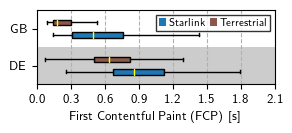

In [156]:
rcParams["font.size"] = 9
def adjust_box(plot):
    for i in range(3,5):
        plt.setp(plot['boxes'][i], facecolor=cols[i], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')


fig, ax = plt.subplots(figsize=(3, 1.4))

star_fcp_abs = {}
terr_fcp_abs = {}
country_list = []

for country_name in ['DE', 'GB']: 
    msm_group = country_name
    delta_time_list = []
    for url in netmet_star_country_url_accumulated_msms_dict[msm_group]:

        if url in netmet_terrestrial_country_url_accumulated_msms_dict[msm_group]:
            terrestrial_xs = np.sort(list(filter(lambda x: x > 0 and x < 2000, netmet_terrestrial_country_url_accumulated_msms_dict[msm_group][url]['first_contentful_paint'])))
            starlink_xs = np.sort(list(filter(lambda x: x > 0 and x < 2000, netmet_star_country_url_accumulated_msms_dict[msm_group][url]['first_contentful_paint'])))

            if len(terrestrial_xs) > 10 and len(starlink_xs) > 10:
                if country_name not in star_fcp_abs:
                    star_fcp_abs[country_name] = []
                if country_name not in terr_fcp_abs:
                    terr_fcp_abs[country_name] = []
                star_fcp_abs[country_name] += [x/1000 for x in list(starlink_xs)]
                terr_fcp_abs[country_name] += [x/1000 for x in list(terrestrial_xs)]
    
    if country_name in star_fcp_abs and country_name in terr_fcp_abs:
        country_list.append(country_name)
                
                
pos1 = np.arange(0, 3 * len(country_list), 3)
pos2 = np.arange(1, 3 * len(country_list) + 1, 3)
ax.boxplot([star_fcp_abs[country] for country in country_list], positions=pos1, patch_artist=True,
           showfliers=False, boxprops=dict(facecolor=cols[0], lw=1), medianprops=dict(color="yellow"),vert=False)
ax.boxplot([terr_fcp_abs[country] for country in country_list], positions=pos2, patch_artist=True,
           showfliers=False, boxprops=dict(facecolor=cols[5], lw=1), medianprops=dict(color="yellow"),vert=False)

ax.axhspan(-1, 2, facecolor="k", alpha=0.2)

ax.set_yticks(np.arange(0.5, 3 * len(country_list), 3))
ax.set_yticklabels(country_list)
ax.set_xlabel("First Contentful Paint (FCP) [s]")
ax.set_xticks(np.arange(0, 2.2, 0.3))

ax.set_ylim(-1,5)
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

labels = ["Starlink", "Terrestrial"]

ax.legend([Patch(facecolor=cols[0]), Patch(facecolor=cols[5])], labels, loc="upper right", fontsize="small", edgecolor="k", handlelength=0.7, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4, borderpad=0.3)
plt.grid(True, axis="x", linestyle="--")
plt.xlim(0,2.1)
fig.tight_layout()

plt.savefig("../Figs/fcp_abs_boxplot_horizontal.pdf", bbox_inches = "tight", pad_inches = 0)
# plt.savefig("../Figs/fcp_abs_boxplot_horizontal.svg", bbox_inches = "tight", pad_inches = 0)
plt.show()

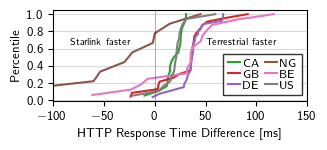

In [157]:
fig, ax = plt.subplots(figsize=(3.37, 1.6))
rcParams["font.size"] = 10
color_idx = 2
common_country_list = set(netmet_terrestrial_country_url_accumulated_msms_dict.keys()).intersection(set(netmet_star_country_url_accumulated_msms_dict.keys()))

for country_name in common_country_list: #msm_group, http_response_list
    msm_group = country_name

    delta_time_list = []
    for url in netmet_star_country_url_accumulated_msms_dict[msm_group]:

        if url in netmet_terrestrial_country_url_accumulated_msms_dict[msm_group]:
            terrestrial_xs = np.sort(list(filter(lambda x: x > 0 and x < 200, netmet_terrestrial_country_url_accumulated_msms_dict[msm_group][url]['http_response'])))
            starlink_xs = np.sort(list(filter(lambda x: x > 0 and x < 200, netmet_star_country_url_accumulated_msms_dict[msm_group][url]['http_response'])))

            if len(terrestrial_xs) and len(starlink_xs):
                delta_time_list.append(statistics.median(list(starlink_xs)) - statistics.median(list(terrestrial_xs)))
    
    if (delta_time_list):
        delta_xs = np.sort(delta_time_list)
        delta_ys = np.arange(1, len(delta_xs) + 1) / len(delta_xs)
        indices = []
        current = delta_xs[0]
        for i, x in enumerate(delta_xs): # only take max y value at each x value to smoothen out the graph
            if x != current:
                current = x
                indices.append(i - 1)
        indices.append(len(delta_ys) - 1)
        delta_xs = sorted(set(delta_xs))
        delta_ys = [delta_ys[i] for i in indices] 
        ax.plot(delta_xs, delta_ys, label=msm_group, color=cols[color_idx], linestyle='solid')
        
        color_idx += 1

ax.set_xlabel("HTTP Response Time Difference [ms]")
ax.set_ylabel("Percentile")
ax.set_yticks(np.arange(0, 1.20, 0.20))
ax.set_xticks(np.arange(-100, 160, 50))

ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False
ax.axvline(x=0, linewidth=0.8, color="black", linestyle="-", alpha=0.3)
ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

ax.text(-83, 0.65, "Starlink faster", fontsize="x-small")
ax.text(50, 0.65, "Terrestrial faster", fontsize="x-small")
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
plt.xlim(-100,150)

fig.tight_layout()
plt.savefig("../Figs/starlink_vs_terrestrial_country_wise_http_delta.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# CLOUDFLARE

In [186]:
cloudflare_glob = f"{cloudflare_msm_path}{cloudflare_msm_folder}/cloudflare_AIM_Global_results-202403-202406.jsonl"

starlink_cdn_latency_countrycode = {}
starlink_cdn_latency_countryname = {}

starlink_cdn_loadedlatency_download_countryname = {}
starlink_cdn_loadedlatency_upload_countryname = {}

starlink_cdn_loadedlatency_download_city_to_cdn = {}
starlink_cdn_loadedlatency_upload_city_to_cdn = {}

starlink_country_to_city_map = {}
starlink_user_to_cdnloc_map ={}
starlink_user_to_cdnloc_minRTT_map ={}

code_country_json = json.load(open(f"{helper_files_path}{helper_folder}/code_to_country_name.json","r"))

with jsonlines.open(cloudflare_glob) as reader:
    for obj in reader:
        country = obj['clientCountry']
        city_name = obj['clientCity']
        server_loc = obj['serverPoP']
        
        if len(obj['latencyMs']) == 20:
            if country not in starlink_cdn_latency_countrycode:
                starlink_cdn_latency_countrycode[country] = []
            starlink_cdn_latency_countrycode[country] += obj['latencyMs']

            if country in code_country_json:
                country_name = code_country_json[country]
                if country_name not in starlink_cdn_latency_countryname:
                    starlink_cdn_latency_countryname[country_name] = []
                    starlink_cdn_loadedlatency_download_countryname[country_name] = []
                    starlink_cdn_loadedlatency_upload_countryname[country_name] = []
                starlink_cdn_latency_countryname[country_name] += obj['latencyMs']

                if city_name not in starlink_cdn_loadedlatency_download_city_to_cdn:
                    starlink_cdn_loadedlatency_download_city_to_cdn[city_name] = {}
                if city_name not in starlink_cdn_loadedlatency_upload_city_to_cdn:
                    starlink_cdn_loadedlatency_upload_city_to_cdn[city_name] = {}
                
                if server_loc not in starlink_cdn_loadedlatency_download_city_to_cdn[city_name]:
                    starlink_cdn_loadedlatency_download_city_to_cdn[city_name][server_loc] = []
                if server_loc not in starlink_cdn_loadedlatency_upload_city_to_cdn[city_name]:
                    starlink_cdn_loadedlatency_upload_city_to_cdn[city_name][server_loc] = []

                if 'download' in obj['loadedLatencyMs']:
                    if len(obj['loadedLatencyMs']['download']):
                        dw_inflationRTT = max(obj['loadedLatencyMs']['download']) - min(obj['loadedLatencyMs']['download'])
                        starlink_cdn_loadedlatency_download_countryname[country_name].append(dw_inflationRTT)
                        starlink_cdn_loadedlatency_download_city_to_cdn[city_name][server_loc].append(dw_inflationRTT)
                if 'upload' in obj['loadedLatencyMs']:
                    if len(obj['loadedLatencyMs']['upload']):
                        up_inflationRTT = max(obj['loadedLatencyMs']['upload']) - min(obj['loadedLatencyMs']['upload'])
                        starlink_cdn_loadedlatency_upload_countryname[country_name].append(up_inflationRTT)
                        starlink_cdn_loadedlatency_upload_city_to_cdn[city_name][server_loc].append(up_inflationRTT)


                if country_name not in starlink_country_to_city_map:
                    starlink_country_to_city_map[country_name] = []
                if city_name not in starlink_country_to_city_map[country_name]:
                    starlink_country_to_city_map[country_name].append(city_name)

                if city_name not in starlink_user_to_cdnloc_map:
                    starlink_user_to_cdnloc_map[city_name] = {}
                    starlink_user_to_cdnloc_minRTT_map[city_name] = {}
                
                if server_loc not in starlink_user_to_cdnloc_map[city_name]:
                    starlink_user_to_cdnloc_map[city_name][server_loc] = []
                    starlink_user_to_cdnloc_minRTT_map[city_name][server_loc] = []
                starlink_user_to_cdnloc_map[city_name][server_loc] += obj['latencyMs']
                starlink_user_to_cdnloc_minRTT_map[city_name][server_loc].append(min(obj['latencyMs']))

            else:
                pass


In [187]:
cloudflare_glob_terrestrial_file = f"{cloudflare_msm_path}{cloudflare_msm_folder}/big_query_all_countries_client_facing_terrestrial_measurements.json"
cloudflare_terrestrial_glob_json = json.load(open(cloudflare_glob_terrestrial_file,"r"))
print(f'JSON file loaded, length is {len(cloudflare_terrestrial_glob_json)} items')

terrestrial_cdn_latency_countrycode = {}
terrestrial_cdn_latency_countryname = {}


terrestrial_cdn_loadedlatency_download_countryname = {}
terrestrial_cdn_loadedlatency_upload_countryname = {}

terrestrial_cdn_loadedlatency_download_city_to_cdn = {}
terrestrial_cdn_loadedlatency_upload_city_to_cdn = {}

terrestrial_country_to_city_map ={}
terrestrial_user_to_cdnloc_map ={}
terrestrial_user_to_cdnloc_minRTT_map ={}

code_country_json = json.load(open(f"{helper_files_path}{helper_folder}/code_to_country_name.json","r"))
idx = 0
for obj in cloudflare_terrestrial_glob_json:
    idx += 1
    country = obj['clientCountry']
    city_name = obj['clientCity']
    server_loc = obj['serverPoP']

    if len(obj['latencyMs']) == 20:
        if country not in terrestrial_cdn_latency_countrycode:
            terrestrial_cdn_latency_countrycode[country] = []
        terrestrial_cdn_latency_countrycode[country] += obj['latencyMs']

        if country in code_country_json:
            country_name = code_country_json[country]
            if country_name not in terrestrial_cdn_latency_countryname:
                terrestrial_cdn_latency_countryname[country_name] = []
                terrestrial_cdn_loadedlatency_download_countryname[country_name] = []
                terrestrial_cdn_loadedlatency_upload_countryname[country_name] = []
            terrestrial_cdn_latency_countryname[country_name] += obj['latencyMs']

            if city_name not in terrestrial_cdn_loadedlatency_download_city_to_cdn:
                    terrestrial_cdn_loadedlatency_download_city_to_cdn[city_name] = {}
            if city_name not in terrestrial_cdn_loadedlatency_upload_city_to_cdn:
                terrestrial_cdn_loadedlatency_upload_city_to_cdn[city_name] = {}
            
            if server_loc not in terrestrial_cdn_loadedlatency_download_city_to_cdn[city_name]:
                terrestrial_cdn_loadedlatency_download_city_to_cdn[city_name][server_loc] = []
            if server_loc not in terrestrial_cdn_loadedlatency_upload_city_to_cdn[city_name]:
                terrestrial_cdn_loadedlatency_upload_city_to_cdn[city_name][server_loc] = []

            if 'download' in obj['loadedLatencyMs']:
                if len(obj['loadedLatencyMs']['download']):
                    dw_inflationRTT = max(obj['loadedLatencyMs']['download']) - min(obj['loadedLatencyMs']['download'])
                    terrestrial_cdn_loadedlatency_download_countryname[country_name].append(dw_inflationRTT)
                    terrestrial_cdn_loadedlatency_download_city_to_cdn[city_name][server_loc].append(dw_inflationRTT)
            if 'upload' in obj['loadedLatencyMs']:
                if len(obj['loadedLatencyMs']['upload']):
                    up_inflationRTT = max(obj['loadedLatencyMs']['upload']) - min(obj['loadedLatencyMs']['upload'])
                    terrestrial_cdn_loadedlatency_upload_countryname[country_name].append(up_inflationRTT)
                    terrestrial_cdn_loadedlatency_upload_city_to_cdn[city_name][server_loc].append(up_inflationRTT)

            if country_name not in terrestrial_country_to_city_map:
                terrestrial_country_to_city_map[country_name] = []
            if city_name not in terrestrial_country_to_city_map[country_name]:
                terrestrial_country_to_city_map[country_name].append(city_name)

            if city_name not in terrestrial_user_to_cdnloc_map:
                terrestrial_user_to_cdnloc_map[city_name] = {}
                terrestrial_user_to_cdnloc_minRTT_map[city_name] = {}
            
            if server_loc not in terrestrial_user_to_cdnloc_map[city_name]:
                terrestrial_user_to_cdnloc_map[city_name][server_loc] = []
                terrestrial_user_to_cdnloc_minRTT_map[city_name][server_loc] = []
            terrestrial_user_to_cdnloc_map[city_name][server_loc] += obj['latencyMs']
            terrestrial_user_to_cdnloc_minRTT_map[city_name][server_loc].append(min(obj['latencyMs']))
        else:
            pass


JSON file loaded, length is 835882 items


/var/folders/6h/lb4zy10n69qgx1bpl1s10qp00000gn/T/ipykernel_23881/3715233465.py:45: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


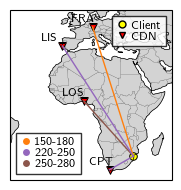

In [188]:


city_name = 'Maputo'

city_locs = {
    'Loc': ['Maputo'],
    'Latitude': [-25.9692],
    'Longitude': [32.5732]
}


city_df = pd.DataFrame(city_locs)

cdn_locs = {
    'Loc': [],
    'Latitude': [],
    'Longitude': [],
    'MedianRTT': []
}

iata_csv_reader = csv.reader(open(f'{helper_files_path}{helper_folder}/iata-icao.csv','r'), delimiter=',')

for row in iata_csv_reader:
    if row[2] == "CDG":
        continue
    if row[2] in list(starlink_user_to_cdnloc_map[city_name].keys()):
        cdn_locs['Loc'].append(row[2])
        cdn_locs['Latitude'].append(float(row[-2]))
        cdn_locs['Longitude'].append(float(row[-1]))
        cdn_locs['MedianRTT'].append(statistics.median(starlink_user_to_cdnloc_map[city_name][row[2]]))




cdn_df = pd.DataFrame(cdn_locs)
cdn_coordinates = geopandas.GeoDataFrame(cdn_df, geometry=geopandas.points_from_xy(cdn_df.Longitude, cdn_df.Latitude))
city_coordinates = geopandas.GeoDataFrame(city_df, geometry=geopandas.points_from_xy(city_df.Longitude, city_df.Latitude))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = pltColors.ListedColormap(cols[:-4])
bkt_cols = cols[:]

ax.coastlines(linewidth=0.5)
cmap = 'Reds'
world.plot(facecolor ="#D3D3D3", edgecolor="black", ax=ax, linewidth=0.1)
city_coordinates.plot(marker="o", facecolor="yellow", edgecolor="black", ax=ax, markersize=30, linewidth=0.7, alpha=1.0)
cdn_coordinates.plot(marker="v", facecolor="red", edgecolor="black", ax=ax, markersize=30, linewidth=0.7, alpha=1.0)

ax.set_extent([-40, 55, -40, 60], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])



buckets = [150,180,200,220,250]
labels = ["130-150", "150-180", "180-200", "200-220","220-250", "250-280"]

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in bkt_cols]


bkt_list_idx = []
for idx in range(len(cdn_locs['Loc'])):
    ax.text(cdn_locs['Longitude'][idx]-12,cdn_locs['Latitude'][idx]+3,cdn_locs['Loc'][idx],weight="bold",fontsize=8)
    bkt_idx = 0
    for bucket in buckets:
        if cdn_locs['MedianRTT'][idx] < bucket:
            break
        bkt_idx += 1
    plt.plot([city_locs['Longitude'][0], cdn_locs['Longitude'][idx]],[city_locs['Latitude'][0], cdn_locs['Latitude'][idx]], linewidth=1, linestyle ="solid", color=bkt_cols[bkt_idx])
    bkt_list_idx.append(bkt_idx)


handle_list = []
label_list = []
for index in range(len(bkt_cols)):
    if index in bkt_list_idx:
        handle_list.append(Line2D([0], [0], marker="o", color="w", markerfacecolor=bkt_cols[index]))
        label_list.append(labels[index])


leg1 = ax.legend(handle_list, label_list, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")
ax.add_artist(leg1)

loc_handles = [Line2D([0], [0], marker="o", color="w", markeredgecolor="black",markersize=5, markerfacecolor='yellow'), Line2D([0], [0], marker="v", color="w", markeredgecolor="black",markersize=5, markerfacecolor='red')]

ax.legend(loc_handles, ['Client', 'CDN'], handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper right", fancybox=False, edgecolor="k", fontsize="small")

fig.tight_layout()
plt.savefig(f"../Figs/starlink_{city_name.lower()}_cdn_latency.pdf", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

/var/folders/6h/lb4zy10n69qgx1bpl1s10qp00000gn/T/ipykernel_23881/3954771109.py:42: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


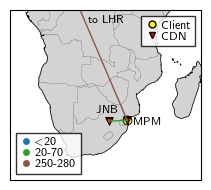

In [189]:
city_name = 'Maputo'

city_locs = {
    'Loc': ['Maputo'],
    'Latitude': [-25.9692],
    'Longitude': [32.5732]
}

city_df = pd.DataFrame(city_locs)

cdn_locs = {
    'Loc': [],
    'Latitude': [],
    'Longitude': [],
    'MedianRTT': []
}

iata_csv_reader = csv.reader(open(f'{helper_files_path}{helper_folder}/iata-icao.csv','r'), delimiter=',')

for row in iata_csv_reader:
    if row[2] == "CDG":
        continue
    if row[2] in list(terrestrial_user_to_cdnloc_map[city_name].keys()):
        cdn_locs['Loc'].append(row[2])
        cdn_locs['Latitude'].append(float(row[-2]))
        cdn_locs['Longitude'].append(float(row[-1]))
        cdn_locs['MedianRTT'].append(statistics.median(terrestrial_user_to_cdnloc_map[city_name][row[2]]))


cdn_df = pd.DataFrame(cdn_locs)
cdn_coordinates = geopandas.GeoDataFrame(cdn_df, geometry=geopandas.points_from_xy(cdn_df.Longitude, cdn_df.Latitude))
city_coordinates = geopandas.GeoDataFrame(city_df, geometry=geopandas.points_from_xy(city_df.Longitude, city_df.Latitude))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = pltColors.ListedColormap(cols[:-4])
bkt_cols = [cols[0],cols[2],cols[3],cols[3],cols[4],cols[6],cols[5]]

ax.coastlines(linewidth=0.5)
cmap = 'Reds'
world.plot(facecolor ="#D3D3D3", edgecolor="black", ax=ax, linewidth=0.1)
city_coordinates.plot(marker="o", facecolor="yellow", edgecolor="black", ax=ax, markersize=40, linewidth=0.7, alpha=1.0)
cdn_coordinates.plot(marker="v", facecolor="red", edgecolor="black", ax=ax, markersize=30, linewidth=0.7, alpha=1.0)

ax.set_extent([5, 50, -40, 0], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

buckets = [20,70,100,150,200,250,280]
labels = ["$<$20", "20-70", "70-100", "100-150","150-200", "200-250","250-280"]

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in bkt_cols]

bkt_list_idx = []
for idx in range(len(cdn_locs['Loc'])):
    if not cdn_locs['Loc'][idx] in ["LHR","MPM"]:
        ax.text(cdn_locs['Longitude'][idx]-3,cdn_locs['Latitude'][idx]+2,cdn_locs['Loc'][idx],weight="bold",fontsize=8)
    bkt_idx = 0
    for bucket in buckets:
        if cdn_locs['MedianRTT'][idx] < bucket:
            break
        bkt_idx += 1
    plt.plot([city_locs['Longitude'][0], cdn_locs['Longitude'][idx]],[city_locs['Latitude'][0], cdn_locs['Latitude'][idx]], linewidth=1, linestyle ="solid", color=bkt_cols[bkt_idx])
    bkt_list_idx.append(bkt_idx)

ax.text(cdn_locs['Longitude'][idx]-5,cdn_locs['Latitude'][idx]+23,"to LHR",weight="bold",fontsize=8)
ax.text(cdn_locs['Longitude'][idx]+6,cdn_locs['Latitude'][idx]-1,"MPM",weight="bold",fontsize=8)
handle_list = []
label_list = []
for index in range(len(bkt_cols)):
    if index in bkt_list_idx:
        handle_list.append(Line2D([0], [0], marker="o", color="w", markerfacecolor=bkt_cols[index]))
        label_list.append(labels[index])

leg1 = ax.legend(handle_list, label_list, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")
ax.add_artist(leg1)

loc_handles = [Line2D([0], [0], marker="o", color="w", markeredgecolor="black",markersize=5, markerfacecolor='yellow'), Line2D([0], [0], marker="v", color="w", markeredgecolor="black",markersize=5, markerfacecolor='red')]

ax.legend(loc_handles, ['Client', 'CDN'], handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper right", fancybox=False, edgecolor="k", fontsize="small")

fig.tight_layout()
plt.savefig(f"../Figs/terrestrial_{city_name}_cdn_latency.pdf", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

In [190]:
terrestrial_user_to_bestcdn_map = {}
terrestrial_user_to_bestcdn_minRTT_map = {}

for user_city, cdn_latency_dict in terrestrial_user_to_cdnloc_map.items():
    temp_dict = {}
    for cdn_loc, latency_list in cdn_latency_dict.items():
        if len(latency_list) >= 100:
            temp_dict[cdn_loc] = statistics.median(latency_list)
    if temp_dict :
        key_of_min = min(temp_dict, key=temp_dict.get)
        terrestrial_user_to_bestcdn_map[user_city] = {
            key_of_min : cdn_latency_dict[key_of_min]
        }

        terrestrial_user_to_bestcdn_minRTT_map[user_city] = {
            key_of_min: terrestrial_user_to_cdnloc_minRTT_map[user_city][key_of_min]
        }

In [191]:
starlink_user_to_bestcdn_map = {}
starlink_user_to_bestcdn_minRTT_map = {}

for user_city, cdn_latency_dict in starlink_user_to_cdnloc_map.items():
    temp_dict = {}
    for cdn_loc, latency_list in cdn_latency_dict.items():
        if len(latency_list) >= 100:
            temp_dict[cdn_loc] = statistics.median(latency_list)
    if temp_dict :
        key_of_min = min(temp_dict, key=temp_dict.get)
        starlink_user_to_bestcdn_map[user_city] = {
            key_of_min : cdn_latency_dict[key_of_min]
        }

        starlink_user_to_bestcdn_minRTT_map[user_city] = {
            key_of_min: starlink_user_to_cdnloc_minRTT_map[user_city][key_of_min]
        }

In [192]:
terrestrial_cdn_latency_countryname_best_cdn_medianrtts = {}

for country, city_list in terrestrial_country_to_city_map.items():
    if country not in terrestrial_cdn_latency_countryname_best_cdn_medianrtts:
        terrestrial_cdn_latency_countryname_best_cdn_medianrtts[country] = []
    for city in city_list:
        if city in terrestrial_user_to_bestcdn_map:
            for cdn, rtts in terrestrial_user_to_bestcdn_map[city].items():
                terrestrial_cdn_latency_countryname_best_cdn_medianrtts[country] += rtts

In [193]:
starlink_cdn_latency_countryname_best_cdn_medianrtts = {}

for country, city_list in starlink_country_to_city_map.items():
    if country not in starlink_cdn_latency_countryname_best_cdn_medianrtts:
        starlink_cdn_latency_countryname_best_cdn_medianrtts[country] = []
    for city in city_list:
        if city in starlink_user_to_bestcdn_map:
            for cdn, rtts in starlink_user_to_bestcdn_map[city].items():
                starlink_cdn_latency_countryname_best_cdn_medianrtts[country] += rtts

/var/folders/6h/lb4zy10n69qgx1bpl1s10qp00000gn/T/ipykernel_23881/1728528415.py:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


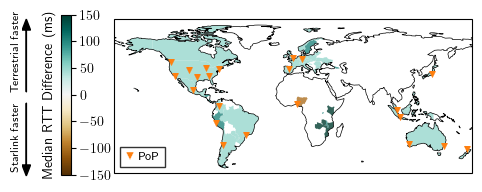

In [194]:
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10, lw=0.6):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = lw,
               label=label)


pop_df = pd.read_csv(f'{helper_files_path}{helper_folder}/pop_locations.csv') #pop_2023-10-10
pop_coords = geopandas.GeoDataFrame(pop_df, geometry=geopandas.points_from_xy(pop_df.long, pop_df.lat))


world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world[(world.name!="Antarctica")]

countries_plotted = set()
median_rtt_difference = []
all_values_list = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name in terrestrial_cdn_latency_countryname_best_cdn_medianrtts and name in starlink_cdn_latency_countryname_best_cdn_medianrtts:
        if len(terrestrial_cdn_latency_countryname_best_cdn_medianrtts[name]) > 25 and len(starlink_cdn_latency_countryname_best_cdn_medianrtts[name]) > 25:
            rtt_diff = statistics.median(starlink_cdn_latency_countryname_best_cdn_medianrtts[name]) - statistics.median(terrestrial_cdn_latency_countryname_best_cdn_medianrtts[name])
            median_rtt_difference.append(rtt_diff)
            countries_plotted.add(name)
            all_values_list.append(rtt_diff)
        else:
            median_rtt_difference.append(float("NaN"))
    elif code == "-99":
        median_rtt_difference.append(float("NaN"))
    else:
        median_rtt_difference.append(float("nan"))



world["rtt_diff"] = median_rtt_difference
fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

total_bins = [-150,-100,-50,0,50,100,160]
handles = []
pop_handles = [Line2D([0], [0], marker="v", color="w", markerfacecolor=cols[1], markeredgewidth=0.3)
           for i in range(1)]
labels = ["PoP"]
handles = pop_handles
ax.coastlines(linewidth=0.5)
cmap = 'BrBG'

world.plot(column="rtt_diff", cmap=cmap, scheme='UserDefined', classification_kwds=dict(bins=total_bins),
           ax=ax,alpha=0.8,)

plot_gsdata(pop_df, ax, "PoP", "v", cols[1], size=20, lw=0.3)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.legend(handles, labels,handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")
 
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=pltColors.Normalize(vmin=-150, vmax=150), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.015, 0.10, 0.02, 0.8])
cbar = fig.colorbar(sm, cax=cbaxes)
cbar.set_label("Median RTT Difference (ms)", labelpad = -50)
cbar.locator = ticker.MaxNLocator(nbins=6)

carrowupaxes = fig.add_axes([-0.070, 0.075, 0.02, 0.4])
carrowupaxes.arrow(0, 0, 0, -0.00005, length_includes_head=True,
          head_width=0.04, head_length=0.0000075, ec="black", fc="black")
carrowupaxes.set_axis_off()

carrowdownaxes = fig.add_axes([-0.070, 0.495, 0.02, 0.4])
carrowdownaxes.arrow(0, 0, 0, 0.00005, length_includes_head=True,
          head_width=0.04, head_length=0.0000075, ec="black", fc="black")
carrowdownaxes.set_axis_off()
plt.figtext(x=-0.095,y=0.120,s="Starlink faster", rotation='vertical', fontsize=8)
plt.figtext(x=-0.095,y=0.520,s="Terrestrial faster", rotation='vertical', fontsize=8)
plt.savefig("../Figs/terrestrial_vs_starlink_rtt_difference_global_heatmap_bestCDN.pdf", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

In [182]:
def find_files(directory, prefix):
    return [f for f in os.listdir(directory) if f.startswith(prefix)]


def parse_timestamp(filename):
    timestamp_str = f"{filename.split('_')[-2]}_{filename.split('_')[-1].split('.')[0]}"
    timestamp = datetime.strptime(timestamp_str, '%Y%m%d_%H%M%S')
    return timestamp


def read_json_file(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)


def process_gsl_files(directory):
    gsl_files = find_files(directory, "gsl_latency_bw_")
    latencies = []
    for file in gsl_files:
        data = read_json_file(os.path.join(directory, file))
        latencies.extend([item['latency'] for item in data])
    print("latencies cdf0:",latencies)
    with open(f"{simulation_msm_path}{simulation_msm_folder}/cdf0", "w") as cdf_file:
        for item in latencies:
            cdf_file.write(str(item) + ",")
    return latencies


def process_path_files(directory):
    print("start processing path files")
    path_files = find_files(directory, "path_")
    print("path files:", path_files)
    results = []
    for file in path_files:
        path_data = read_json_file(os.path.join(directory, file))
        timestamp = parse_timestamp(file)
        # Find corresponding GSL and ISL files
        gsl_file = find_matching_file(directory, "gsl_latency_bw_", timestamp)
        isl_file = find_matching_file(directory, "isl_latency_bw_", timestamp)
        gsl_data = read_json_file(os.path.join(directory, gsl_file))
        isl_data = read_json_file(os.path.join(directory, isl_file))

        # Calculate latencies for cdf1 to cdf5
        latencies = calculate_latencies(path_data, gsl_data, isl_data)
        print("inside:", latencies)
        results.append(latencies)
    print("latencies result other cdfs:", len(results))
    try:
        with open(f"{simulation_msm_path}{simulation_msm_folder}/other_cdfs", "w") as other_cdf_file:
            for items in results:
                other_cdf_file.write("\n")
                for item in items:
                    other_cdf_file.write(str(item) + ",")
    except Exception as e:
        print(e)
        return
    return results


def find_matching_file(directory, prefix, timestamp):
    files = find_files(directory, prefix)
    return min(files, key=lambda x: abs(parse_timestamp(x) - timestamp))


def process_http_responses(filename):
    with open(filename, 'r') as file:
        data = json.load(file)

    http_responses = []
    for outer_key in data:
        for city in data[outer_key]:
            for provider in data[outer_key][city]:
                for location in data[outer_key][city][provider]:
                    filtered_responses = [
                        response for response in data[outer_key][city][provider][location]['http_response']
                        if 25 < response < 80
                    ]
                    http_responses.extend(filtered_responses)

    return http_responses


def calculate_latencies(path_info, gsl_data, isl_data):
    path_filename = path_info[0]
    path = path_info[1:]  # The actual satellite path

    latencies = [0] * 11  # For cdf0 to cdf5

    # Extract start and end stations from the filename
    start_station, end_station = path_filename.split('_')[1:3]

    # Find the GSL latency for the first hop (ground station to first satellite)
    gsl_latency_start = next(
        (item['latency'] for item in gsl_data
         if item['end1'] == start_station and item['end2'] == path[0]),
        0
    )

    latencies[1] = gsl_latency_start  # cdf1 is GSL latency

    # Calculate latencies for cdf2 to cdf5
    for i in range(1, min(10, len(path))):
        isl_latency = next(
            (item['latency'] for item in isl_data
             if (item['end1'] == path[i - 1] and item['end2'] == path[i]) or
             (item['end1'] == path[i] and item['end2'] == path[i - 1])),
            0
        )
        latencies[i + 1] = latencies[i] + isl_latency

    # If path is shorter than 5 hops, repeat the last calculated latency
    last_calculated = next(l for l in reversed(latencies) if l != 0)
    latencies = [l if l != 0 else last_calculated for l in latencies]

    return latencies[1:]  # Return cdf1 to cdf5


def process_path_files(directory):
    path_files = find_files(directory, "path_")
    results = []
    for file in path_files:
        path_data = read_json_file(os.path.join(directory, file))
        timestamp = parse_timestamp(file)

        # Find corresponding GSL and ISL files
        gsl_file = find_matching_file(directory, "gsl_latency_bw_", timestamp)
        isl_file = find_matching_file(directory, "isl_latency_bw_", timestamp)

        gsl_data = read_json_file(os.path.join(directory, gsl_file))
        isl_data = read_json_file(os.path.join(directory, isl_file))

        # Calculate latencies for cdf1 to cdf5
        latencies = calculate_latencies([file] + path_data, gsl_data, isl_data)
        results.append(latencies)

    return results


def read_terrestrial(filename):
    with open(filename, 'r') as file:
        return [x for x in json.load(file) if x < 80]


def create_dataframe(cdf0, other_cdfs, cdf7, cdf8):
    max_length = max(len(cdf0), len(other_cdfs))

    df = pd.DataFrame({
        '1st Sat': pd.Series(
            [row[0] if row else np.nan for row in other_cdfs] + [np.nan] * (max_length - len(other_cdfs))),
        # '1 ISL': pd.Series(cdf0 + [np.nan] * (max_length - len(cdf0))),
        # '2 ISLs': pd.Series([row[1] if row and len(row) > 1 else np.nan for row in other_cdfs] + [np.nan] * (
        #         max_length - len(other_cdfs))),
        '3 ISLs': pd.Series([row[2] if row and len(row) > 2 else np.nan for row in other_cdfs] + [np.nan] * (
                max_length - len(other_cdfs))),
        # '4 ISL to cache': pd.Series([row[3] if row and len(row) > 3 else np.nan for row in other_cdfs] + [np.nan] * (
        #         max_length - len(other_cdfs))),
        '5 ISLs': pd.Series([row[4] if row and len(row) > 4 else np.nan for row in other_cdfs] + [np.nan] * (
                max_length - len(other_cdfs))),
        '10 ISLs': pd.Series([row[9] if row and len(row) > 9 else np.nan for row in other_cdfs] + [np.nan] * (
                max_length - len(other_cdfs))),
        'Starlink': pd.Series(cdf7 + [np.nan] * (max_length - len(cdf7))),
        'Terrestrial': pd.Series(cdf8 + [np.nan] * (max_length - len(cdf8)))
    })

    return df


def plot_cdf(df):
    fig, ax = plt.subplots(figsize=(3.37, 1.7))
    color_idx = 2
    for column in df.columns:
        data = df[column].dropna().sort_values()
        y = np.arange(1, len(data) + 1) / len(data)

        if column in ['Starlink']:
            ax.plot(data, y, label=column, color='black', linestyle='--')
        elif column in ['Terrestrial']:
            ax.plot(data, y, label=column, color='black', linestyle=':')
        else:
            ax.plot(data, y, label=column, color=cols[color_idx])
        color_idx += 1

    ax.set_xlabel('Latency [ms]')
    ax.set_ylabel('Percentile')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    ax.tick_params(axis='y')
    ax.tick_params(axis='x')
    ax.set_ylim(bottom=0.0)
    ax.set_xlim(left=0)

    ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
    fig.tight_layout()
    plt.grid(True, axis="y", alpha=0.7, linewidth=0.5)
    plt.grid(True, axis="x", alpha=0.7, linewidth=0.5)
    plt.rcParams.update({'text.usetex': True})
    plt.savefig('../Figs/cdn_cdf_plot.pdf', bbox_inches='tight')
    plt.show()


def adjust_box(plot, idx):
    for i in range(1):
        plt.setp(plot['boxes'][i], facecolor=cols[idx + 1], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')


def plot_boxplot(df):
    fig, ax = plt.subplots(figsize=(3.37, 1.4))

    # Select the columns for box plots
    columns = ['3 ISLs', '5 ISLs', '10 ISLs']

    # Create box plots for each selected column
    df_box = df[columns]
    boxplot = df_box.boxplot(showfliers=False, patch_artist=True, vert=False, return_type='dict')
    cols = plt.get_cmap("tab10").colors
    i = 2
    for box in boxplot['boxes']:
        # Change the properties of the box 
        box.set(facecolor=cols[i], linewidth=1)
        i += 2

    for box in boxplot['boxes']:
        box.set_edgecolor('black')

        # Set the color of the whiskers (error lines) to black
    for whisker in boxplot['whiskers']:
        whisker.set(color='black')

    # Set the color of the caps to black
    for cap in boxplot['caps']:
        cap.set(color='black')

    # Set the color of the medians to yellow
    for median in boxplot['medians']:
        median.set(color='yellow')

    x_labels = ['80\%', '50\%', '30\%']
    plt.yticks(range(1, len(columns) + 1), x_labels)
    plt.xlabel('Latency [ms]')
    plt.ylabel('Cache-enabled \n Sats')
    plt.axvline(x=17, color='black', linestyle='--', linewidth=2, label='Terrestrial Latency')
    plt.legend(loc='lower right', fontsize="small", edgecolor="k", handlelength=0.7, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4, borderpad=0.3)
    plt.grid(True, axis="x", linestyle="--")
    plt.grid(False, axis="y")
    ax.axhspan(1.5, 2.5, facecolor="k", alpha=0.2)
    fig.tight_layout()
    plt.rcParams.update({'text.usetex': True})
    plt.savefig('../Figs/satellite_cdn_percentile.pdf', bbox_inches='tight')
    plt.show()

In [183]:
directory = f"{simulation_msm_path}{simulation_msm_folder}/results_70terminals_2_/"
http_response_file = f"{simulation_msm_path}{simulation_msm_folder}/06-27-2024-16-12-24_files_list_accumulated_AS14593_msms.json"
terrestrial = f"{simulation_msm_path}{simulation_msm_folder}/Amsterdam_terrestrial_minRTT_to_AMS_CDN.json"
cdf0 = process_gsl_files(directory)
print("running other cdfs")
other_cdfs = process_path_files(directory)
print("result of the cdfs:", other_cdfs)
print("finish running other cdfs")
cdf7 = process_http_responses(http_response_file)
cdf8 = read_terrestrial(terrestrial)
# Create DataFrame
df = create_dataframe(cdf0, other_cdfs, cdf7, cdf8)

latencies cdf0: [1.8731671365788902, 1.9446595101979658, 2.278146012233252, 1.9809178612526668, 2.066271589757575, 1.8489343432932717, 1.977065658375745, 1.8751868525204, 2.199861940431552, 2.1807223535550646, 1.563772189074522, 2.1713366657572477, 1.563772189074522, 1.9702878100696488, 1.8482793718335218, 2.1807223535550646, 2.418282428041093, 1.9429663539412152, 2.1807223535550646, 2.498171005926201, 1.8731671365788902, 2.278146012233252, 1.9083256513589175, 1.8570037073988515, 1.952380633612367, 2.066271589757575, 2.047550669016475, 2.175524892215559, 1.977065658375745, 2.1633444848716312, 1.5022518708606378, 1.8548390091438456, 2.1713366657572477, 3.2977238862747527, 1.8675464261681933, 1.9429663539412152, 1.8751868525204, 1.9947957015861935, 1.563772189074522, 2.0276440939016824, 1.8988151803919264, 1.8489343432932717, 2.418282428041093, 1.8615845798303416, 1.8793647435816645, 2.276596193268967, 2.140657384976318, 3.3240864483560855, 2.3864747424806003, 1.9809178612526668, 2.17516

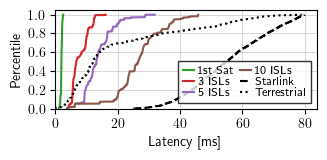

In [184]:
plot_cdf(df)

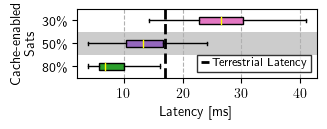

In [185]:
plot_boxplot(df)